In [1]:
%load_ext autoreload
%autoreload 2

# Add the path to the parent directory to sys
import sys, os

# If current directory is called 'notebooks', chdir to the parent
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    
sys.path.append('attribution')

from torch.utils.data import DataLoader

import pandas as pd
from constants import ModelNames, DatasetNames, LANGUAGE_MAPPING
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import json
import numpy as np

qwen_instruct = "Qwen2.5-1.5B-Instruct"
qwen_reasoning = "DeepSeek-R1-Distill-Qwen-1.5B"

## Performance in English with and without COT and Structured Generation

In [7]:
def plot_english_performance(accuracy_values, save_dir='results/plots/', plot_filename='eng_baseline.png'):
    """
    Plot performance of different conditions in English.
    
    Parameters:
    -----------
    accuracy_values : dict
        Dictionary with conditions as keys and accuracy values as values.
        Example: {'Regular': 0.5, 'Direct Answer': 0.6, 'COT': 0.7, 'COT + SG': 0.8}
    save_dir : str
        Directory to save the plot. Default is 'results/plots/'.
    plot_filename : str
        Filename for saving the plot. Default is 'eng_baseline.png'.
        
    Returns:
    --------
    None
    """
    
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Complete path for saving the plot
    plot_path = os.path.join(save_dir, plot_filename)
    
    # Ensure plots don't interfere
    plt.close('all')
    
    # Convert to DataFrame format required by seaborn
    df_eng = pd.DataFrame({
        'Condition': list(accuracy_values.keys()),
        'Accuracy': list(value * 100 for value in accuracy_values.values())
    })
    
    plt.figure(figsize=(8, 5))  # Slightly larger figure for better readability
    
    # Create the bar plot
    ax = sns.barplot(x='Condition', y='Accuracy', data=df_eng, palette='viridis')
    
    # Add a grid
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of each bar
    for i, v in enumerate(df_eng['Accuracy']):
        ax.text(i, v + 1, f"{v:.1f}", ha='center', fontsize=9)
    
    # Customize the plot
    plt.ylim(0, 100)
    plt.ylabel('Accuracy (%)')
    
    # Ensure grid is behind bars
    ax.set_axisbelow(True)
    
    # Save and show the plot
    plt.tight_layout()  # Adjust spacing
    plt.savefig(plot_path, dpi=300)  # Higher DPI for better quality
    plt.show()
    print(f"Plot saved as '{plot_path}'")

C:\Users\User\AppData\Local\Temp\ipykernel_2868\3702027433.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Condition', y='Accuracy', data=df_eng, palette='viridis')


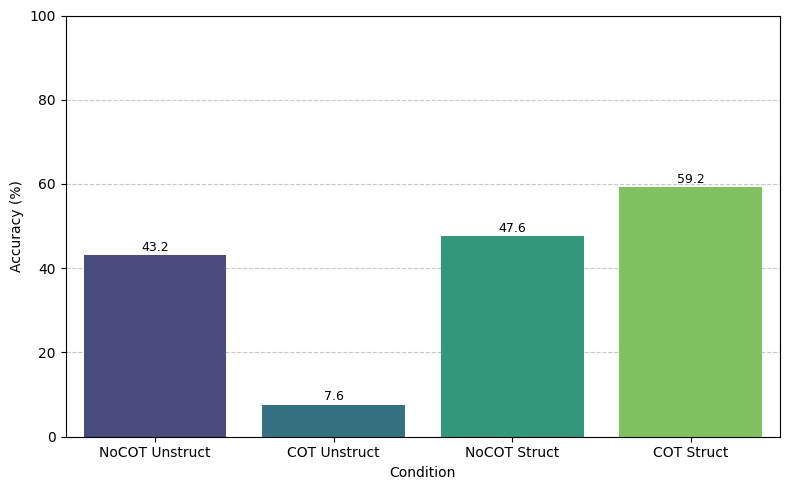

Plot saved as 'results/plots/eng_baseline.png'


In [8]:
# Data dictionary
data = json.load(open('results/metrics/generations.json', 'r'))

# Define output filenames
save_dir = 'results/plots/'

# -----------------------------
# Plot 1: English COT Constrained vs Unconstrained
# -----------------------------
# More convenient structure where conditions are keys to accuracy values
accuracy_values = {
    'NoCOT Unstruct': data["mgsm_en_regular_unconstrained_Qwen2.5-1.5B-Instruct"],
    'COT Unstruct': data["mgsm_en_regular_constrained_Qwen2.5-1.5B-Instruct"],
    'NoCOT Struct': data["mgsm_en_COT_unconstrained_Qwen2.5-1.5B-Instruct"],
    'COT Struct': data["mgsm_en_COT_constrained_Qwen2.5-1.5B-Instruct"],
}

plot_english_performance(accuracy_values)

## Performance across languages with and without COT using constrained decoding

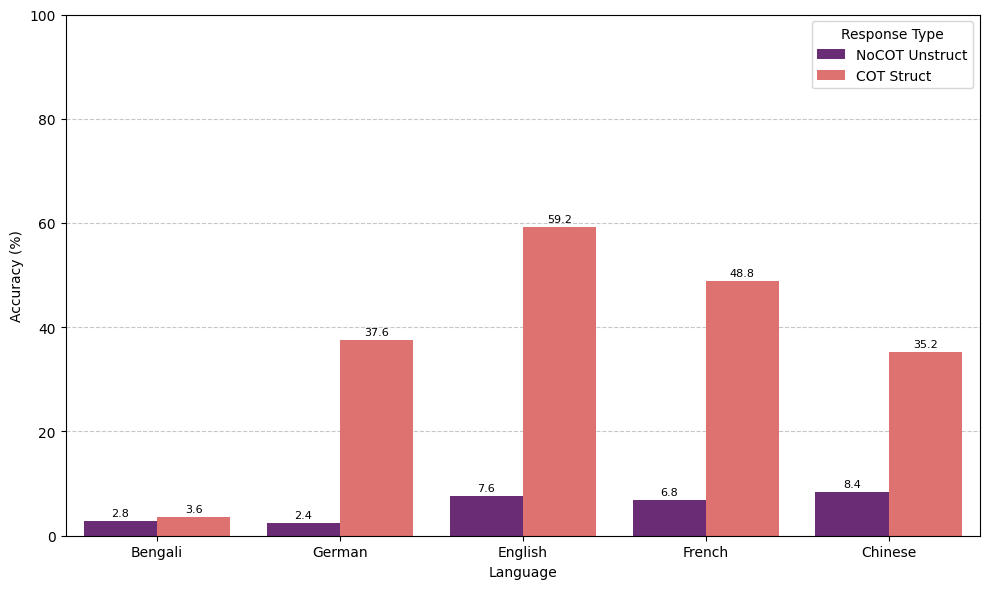

Plot saved as 'results/plots/multi-lang_performance_Qwen2.5-1.5B-Instruct.png'


In [4]:
def plot_language_performance(model_name, save_dir='results/plots/', plot_filename=None, languages=None):
    """
    Plot performance across languages for constrained responses (COT vs Regular).
    
    Parameters:
    -----------
    model_name : str
        Name of the model being analyzed (e.g., 'Qwen2.5-1.5B-Instruct').
        Used for retrieving data keys and generating default filename.
    save_dir : str
        Directory to save the plot. Default is 'results/plots/'.
    plot_filename : str or None
        Filename for saving the plot. If None, will be created based on model name.
        
    Returns:
    --------
    None
    """
    
    # Load data
    data = json.load(open('results/metrics/generations.json', 'r'))
    
    # Set default filename if not provided
    if plot_filename is None:
        plot_filename = f'multi-lang_performance_{model_name}.png'
    
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Complete path for saving the plot
    plot_path = os.path.join(save_dir, plot_filename)
    
    # Define languages to plot
    if languages is None:
        languages = ['bn', 'de', 'en', 'fr', 'zh']
    plot_data = []

    # Collect data for each language
    for lang in languages:
        reg_key = f"mgsm_{lang}_regular_constrained_{model_name}"
        cot_key = f"mgsm_{lang}_COT_constrained_{model_name}"
        
        # Use full language name from LANGUAGE_MAPPING
        lang_name = LANGUAGE_MAPPING[lang]
        
        # Only add data points if the keys exist
        if reg_key in data:
            plot_data.append({'Language': lang_name, 'Type': 'NoCOT Unstruct', 'Accuracy': data[reg_key] * 100})
        if cot_key in data:
            plot_data.append({'Language': lang_name, 'Type': 'COT Struct', 'Accuracy': data[cot_key] * 100})

    # Convert to DataFrame
    df_plot = pd.DataFrame(plot_data)
    
    # Create the plot
    plt.figure(figsize=(10, 6))  # Slightly wider to accommodate language names
    
    # Create the bar plot
    ax = sns.barplot(x='Language', y='Accuracy', hue='Type', data=df_plot, palette='magma')
    
    # Add a grid
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of each bar, but only for non-zero values
    for i, p in enumerate(ax.patches):
        height = p.get_height()
        if height > 0.001:  # Only label bars with non-zero values
            ax.text(p.get_x() + p.get_width()/2., height + 1,
                    f'{height:.1f}', ha="center", fontsize=8)
    
    # Customize the plot
    plt.ylim(0, 100)
    plt.ylabel('Accuracy (%)')
    plt.legend(title='Response Type')
    
    # Ensure grid is behind bars
    ax.set_axisbelow(True)
    
    # Save and show the plot
    plt.tight_layout()  # Adjust spacing
    plt.savefig(plot_path, dpi=300)  # Higher DPI for better quality
    plt.show()
    print(f"Plot saved as '{plot_path}'")
    
# Example usage:
plot_language_performance("Qwen2.5-1.5B-Instruct")

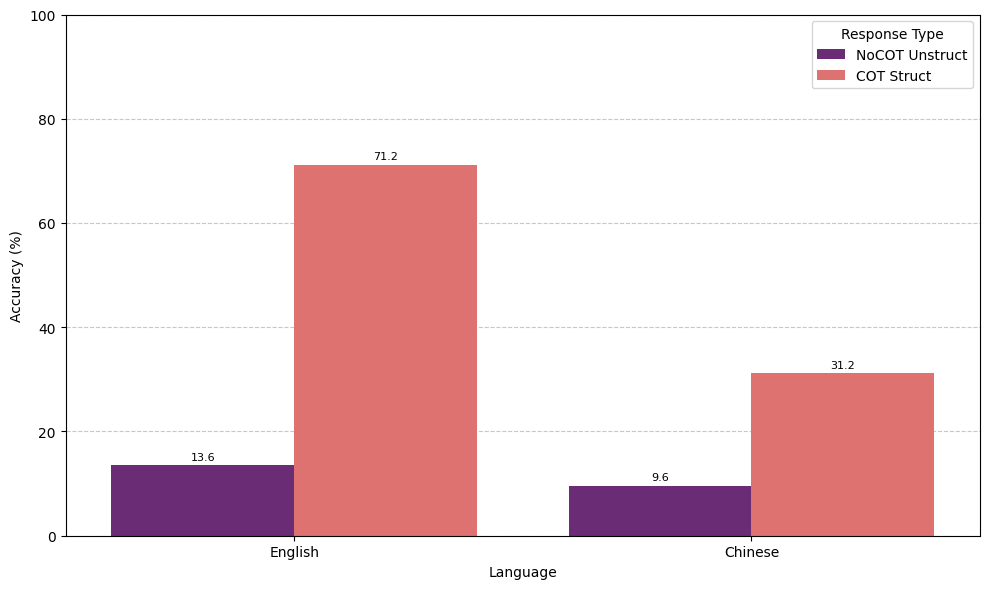

Plot saved as 'results/plots/multi-lang_performance_DeepSeek-R1-Distill-Qwen-1.5B.png'


In [5]:
plot_language_performance("DeepSeek-R1-Distill-Qwen-1.5B", languages=['en', 'zh'])

## Number of tokens across generations

C:\Users\User\AppData\Local\Temp\ipykernel_16216\436932855.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Language', x='Average Token Count', data=token_df, palette='viridis')


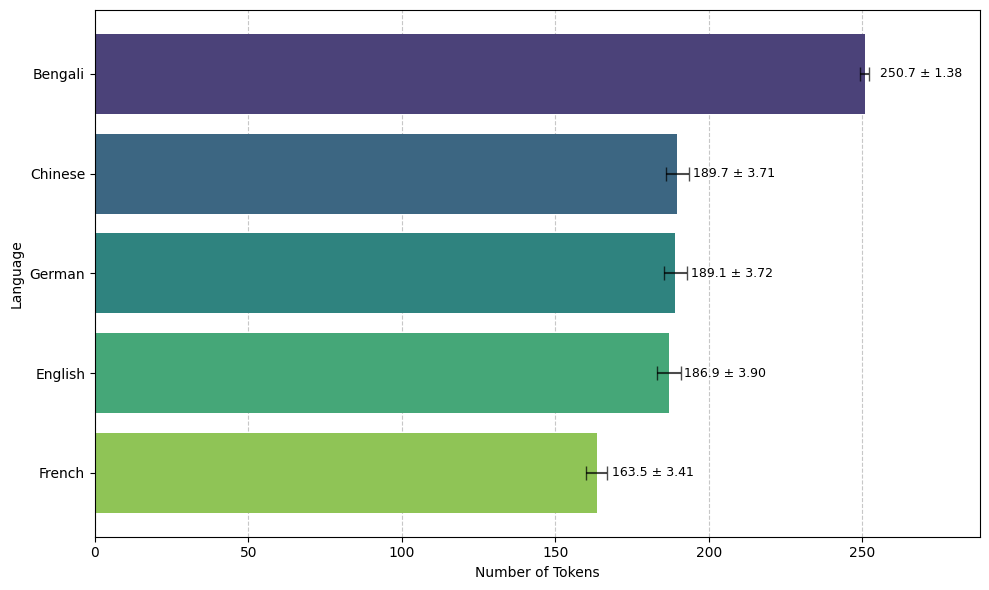

Plot saved as 'results/plots/token_counts_Qwen2.5-1.5B-Instruct.png'


In [66]:
def plot_token_counts(model_name, languages=None, save_dir='results/plots/', plot_filename=None):
    """
    Plot average token counts across languages for a specified model.
    
    Parameters:
    -----------
    model_name : str
        Name of the model being analyzed (e.g., 'Qwen2.5-1.5B-Instruct').
        Used for retrieving data and generating default filename.
    languages : list or None
        List of language codes to analyze. If None, defaults to ['en', 'bn', 'de', 'fr', 'zh'].
    save_dir : str
        Directory to save the plot. Default is 'results/plots/'.
    plot_filename : str or None
        Filename for saving the plot. If None, will be created based on model name.
        
    Returns:
    --------
    pd.DataFrame
        DataFrame containing token count statistics for each language.
    """
    from transformers import AutoTokenizer
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    from constants import ModelNames, LANGUAGE_MAPPING

    # Set default languages if not provided
    if languages is None:
        languages = ['en', 'bn', 'de', 'fr', 'zh']
        
    # Set default filename if not provided
    if plot_filename is None:
        plot_filename = f'token_counts_{model_name}.png'
        
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Complete path for saving the plot
    plot_path = os.path.join(save_dir, plot_filename)
    
    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(ModelNames.QwenInstruct)
    
    # Initialize list to collect token counts
    token_data = []
    
    # Calculate token counts for each language
    for lang in languages:
        file_path = f"results/generations/mgsm_{lang}_COT_constrained_{model_name}_results.csv"
        
        if not os.path.exists(file_path):
            print(f"Warning: File not found: {file_path}")
            continue
        
        # Load generations
        df = pd.read_csv(file_path)
        
        # Calculate token counts for each response
        token_counts = [len(tokenizer.encode(response)) for response in df['response']]
        
        # Calculate statistics
        avg_tokens = np.mean(token_counts)
        std_tokens = np.std(token_counts)
        # Calculate standard error (standard deviation / sqrt(sample size))
        std_error = std_tokens / np.sqrt(len(token_counts))
        
        # Add to data collection
        token_data.append({
            'Language': LANGUAGE_MAPPING[lang],
            'Average Token Count': avg_tokens,
            'Std Error': std_error,
            'Sample Size': len(token_counts)
        })
    
    # Convert to DataFrame and sort by Average Token Count (descending)
    token_df = pd.DataFrame(token_data)
    token_df = token_df.sort_values('Average Token Count', ascending=False).reset_index(drop=True)
    
    # Create horizontal bar plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(y='Language', x='Average Token Count', data=token_df, palette='viridis')
    
    # Add grid
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Add error bars showing standard error
    for i, row in token_df.iterrows():
        plt.errorbar(row['Average Token Count'], i, xerr=row['Std Error'], 
                     fmt='none', color='black', capsize=5, alpha=0.7)
    
    # Add value labels placed at end of bars to avoid overlap
    for i, row in token_df.iterrows():
        # Place label at the end of the bar
        ax.text(row['Average Token Count'] + 5, i, 
                f"{row['Average Token Count']:.1f} ± {row['Std Error']:.2f}", 
                va='center', ha='left', fontsize=9, color='black')
    
    # Customize plot
    # plt.title(f'Average Token Count by Language for {model_name} (COT Responses)')
    plt.xlabel('Number of Tokens')
    plt.xlim(0, token_df['Average Token Count'].max() * 1.15)  # Add extra space for labels
    plt.tight_layout()
    
    # Ensure grid is behind bars
    ax.set_axisbelow(True)
    
    # Save and show
    plt.savefig(plot_path, dpi=300)
    plt.show()
    print(f"Plot saved as '{plot_path}'")

plot_token_counts("Qwen2.5-1.5B-Instruct")

C:\Users\User\AppData\Local\Temp\ipykernel_16216\436932855.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Language', x='Average Token Count', data=token_df, palette='viridis')


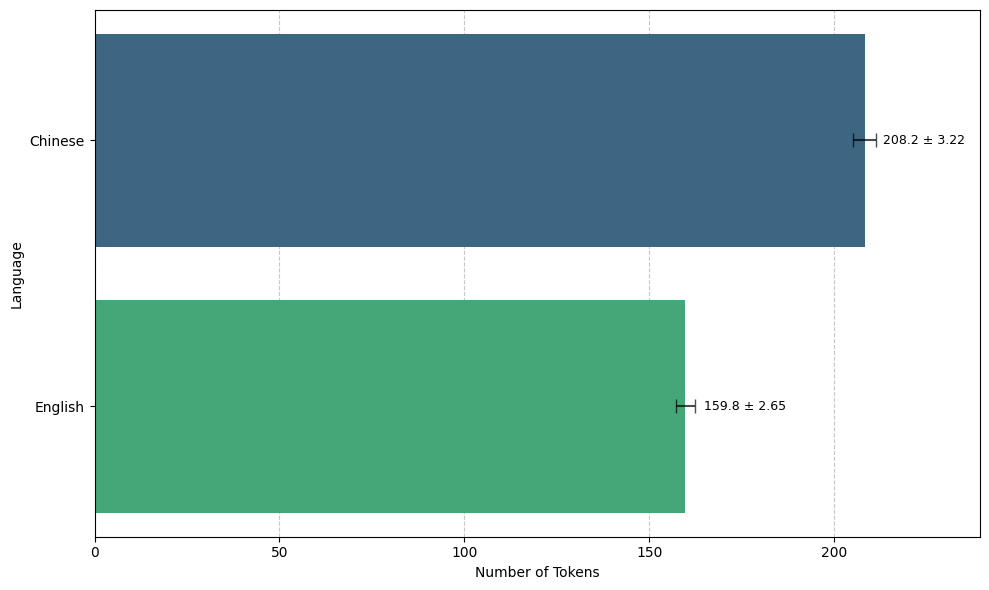

Plot saved as 'results/plots/token_counts_DeepSeek-R1-Distill-Qwen-1.5B.png'


In [29]:
plot_token_counts(qwen_reasoning, languages=['en', 'zh'])

C:\Users\User\AppData\Local\Temp\ipykernel_16216\622269112.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Language', x='Average Step Count', data=step_df, palette='magma')


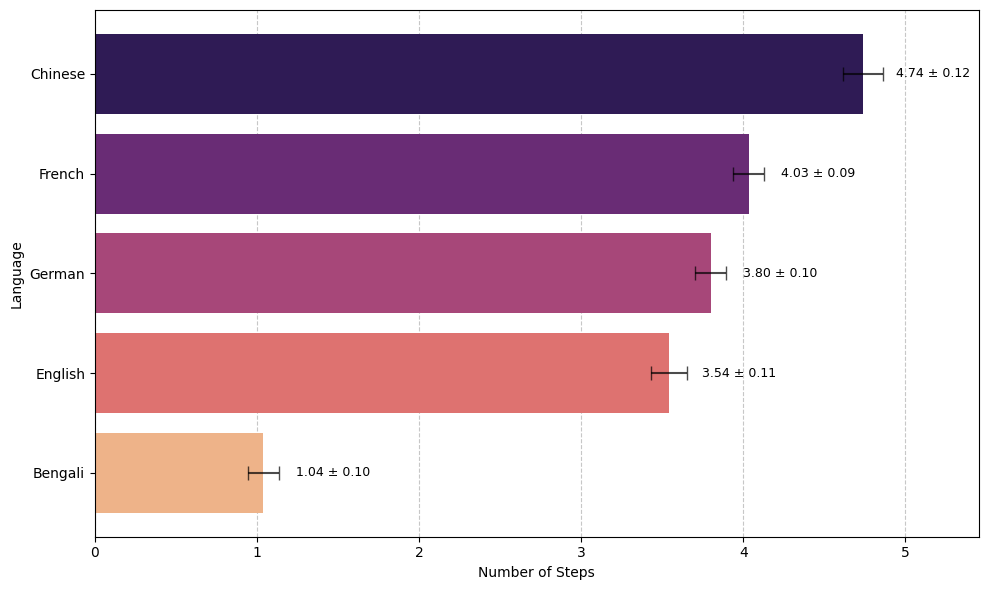

Plot saved as 'results/plots/reasoning_steps_Qwen2.5-1.5B-Instruct.png'


In [32]:
def plot_reasoning_steps(model_name, languages=None, save_dir='results/plots/', plot_filename=None):
    """
    Plot average reasoning step counts across languages for a specified model.
    
    Parameters:
    -----------
    model_name : str
        Name of the model being analyzed (e.g., 'Qwen2.5-1.5B-Instruct').
        Used for retrieving data and generating default filename.
    languages : list or None
        List of language codes to analyze. If None, defaults to ['en', 'bn', 'de', 'fr', 'zh'].
    save_dir : str
        Directory to save the plot. Default is 'results/plots/'.
    plot_filename : str or None
        Filename for saving the plot. If None, will be created based on model name.
        
    Returns:
    --------
    pd.DataFrame
        DataFrame containing reasoning step count statistics for each language.
    """
    
    # Set default languages if not provided
    if languages is None:
        languages = ['en', 'bn', 'de', 'fr', 'zh']
    
    # Set default filename if not provided
    if plot_filename is None:
        plot_filename = f'reasoning_steps_{model_name}.png'
    
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Complete path for saving the plot
    plot_path = os.path.join(save_dir, plot_filename)
    
    # Initialize list to collect reasoning step counts
    step_data = []
    
    # Calculate reasoning steps for each language
    for lang in languages:
        file_path = f"results/generations/mgsm_{lang}_COT_constrained_{model_name}_results.csv"
        
        if not os.path.exists(file_path):
            print(f"Warning: File not found: {file_path}")
            continue
        
        # Load generations
        df = pd.read_csv(file_path)
        
        # Calculate reasoning steps for each response (newlines - 2)
        step_counts = [response.count('\n') - 2 for response in df['response']]
        
        # Calculate statistics
        avg_steps = np.mean(step_counts)
        std_steps = np.std(step_counts)
        # Calculate standard error (standard deviation / sqrt(sample size))
        std_error = std_steps / np.sqrt(len(step_counts))
        
        # Add to data collection
        step_data.append({
            'Language': LANGUAGE_MAPPING[lang],
            'Average Step Count': avg_steps,
            'Std Error': std_error,
            'Sample Size': len(step_counts)
        })
    
    # Convert to DataFrame and sort by Average Step Count (descending)
    step_df = pd.DataFrame(step_data)
    step_df = step_df.sort_values('Average Step Count', ascending=False).reset_index(drop=True)
    
    # Create horizontal bar plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(y='Language', x='Average Step Count', data=step_df, palette='magma')
    
    # Add grid
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Add error bars showing standard error
    for i, row in step_df.iterrows():
        plt.errorbar(row['Average Step Count'], i, xerr=row['Std Error'], 
                     fmt='none', color='black', capsize=5, alpha=0.7)
    
    # Add value labels placed at end of bars
    for i, row in step_df.iterrows():
        # Place label at the end of the bar
        ax.text(row['Average Step Count'] + 0.2, i, 
                f"{row['Average Step Count']:.2f} ± {row['Std Error']:.2f}", 
                va='center', ha='left', fontsize=9, color='black')
    
    # Customize plot
    # plt.title(f'Average Number of Reasoning Steps by Language ({model_name})')
    plt.xlabel('Number of Steps')
    plt.xlim(0, step_df['Average Step Count'].max() * 1.15)  # Add extra space for labels
    plt.tight_layout()
    
    # Ensure grid is behind bars
    ax.set_axisbelow(True)
    
    # Save and show
    plt.savefig(plot_path, dpi=300)
    plt.show()
    print(f"Plot saved as '{plot_path}'")

plot_reasoning_steps(qwen_instruct)

C:\Users\User\AppData\Local\Temp\ipykernel_16216\622269112.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Language', x='Average Step Count', data=step_df, palette='magma')


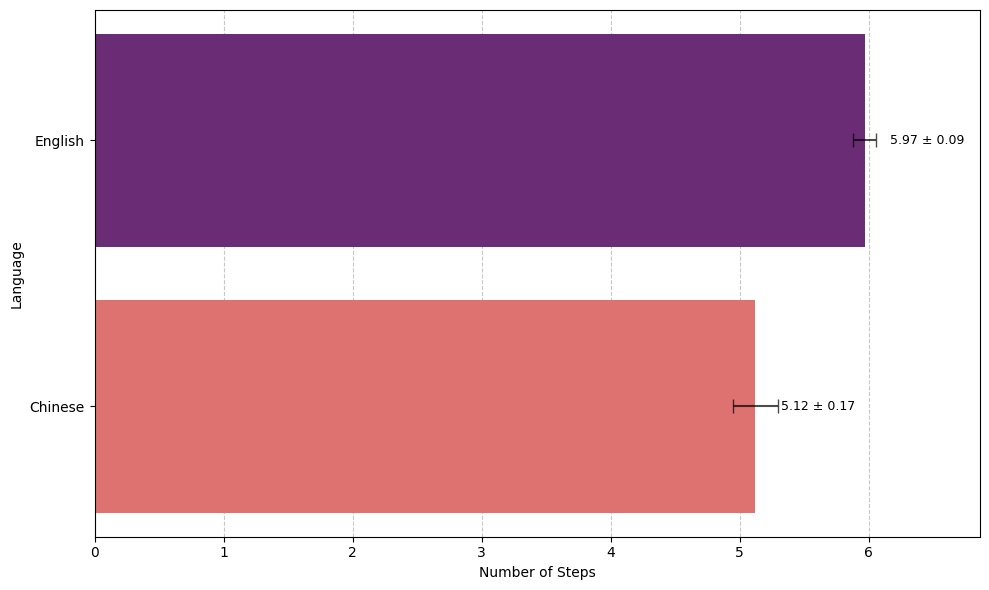

Plot saved as 'results/plots/reasoning_steps_DeepSeek-R1-Distill-Qwen-1.5B.png'


In [33]:
plot_reasoning_steps(qwen_reasoning, languages=['en', 'zh'])

## Analyzing importance of Steps


Invalid response counts:
English: 0
Bengali: 33
German: 0
French: 0
Chinese: 0


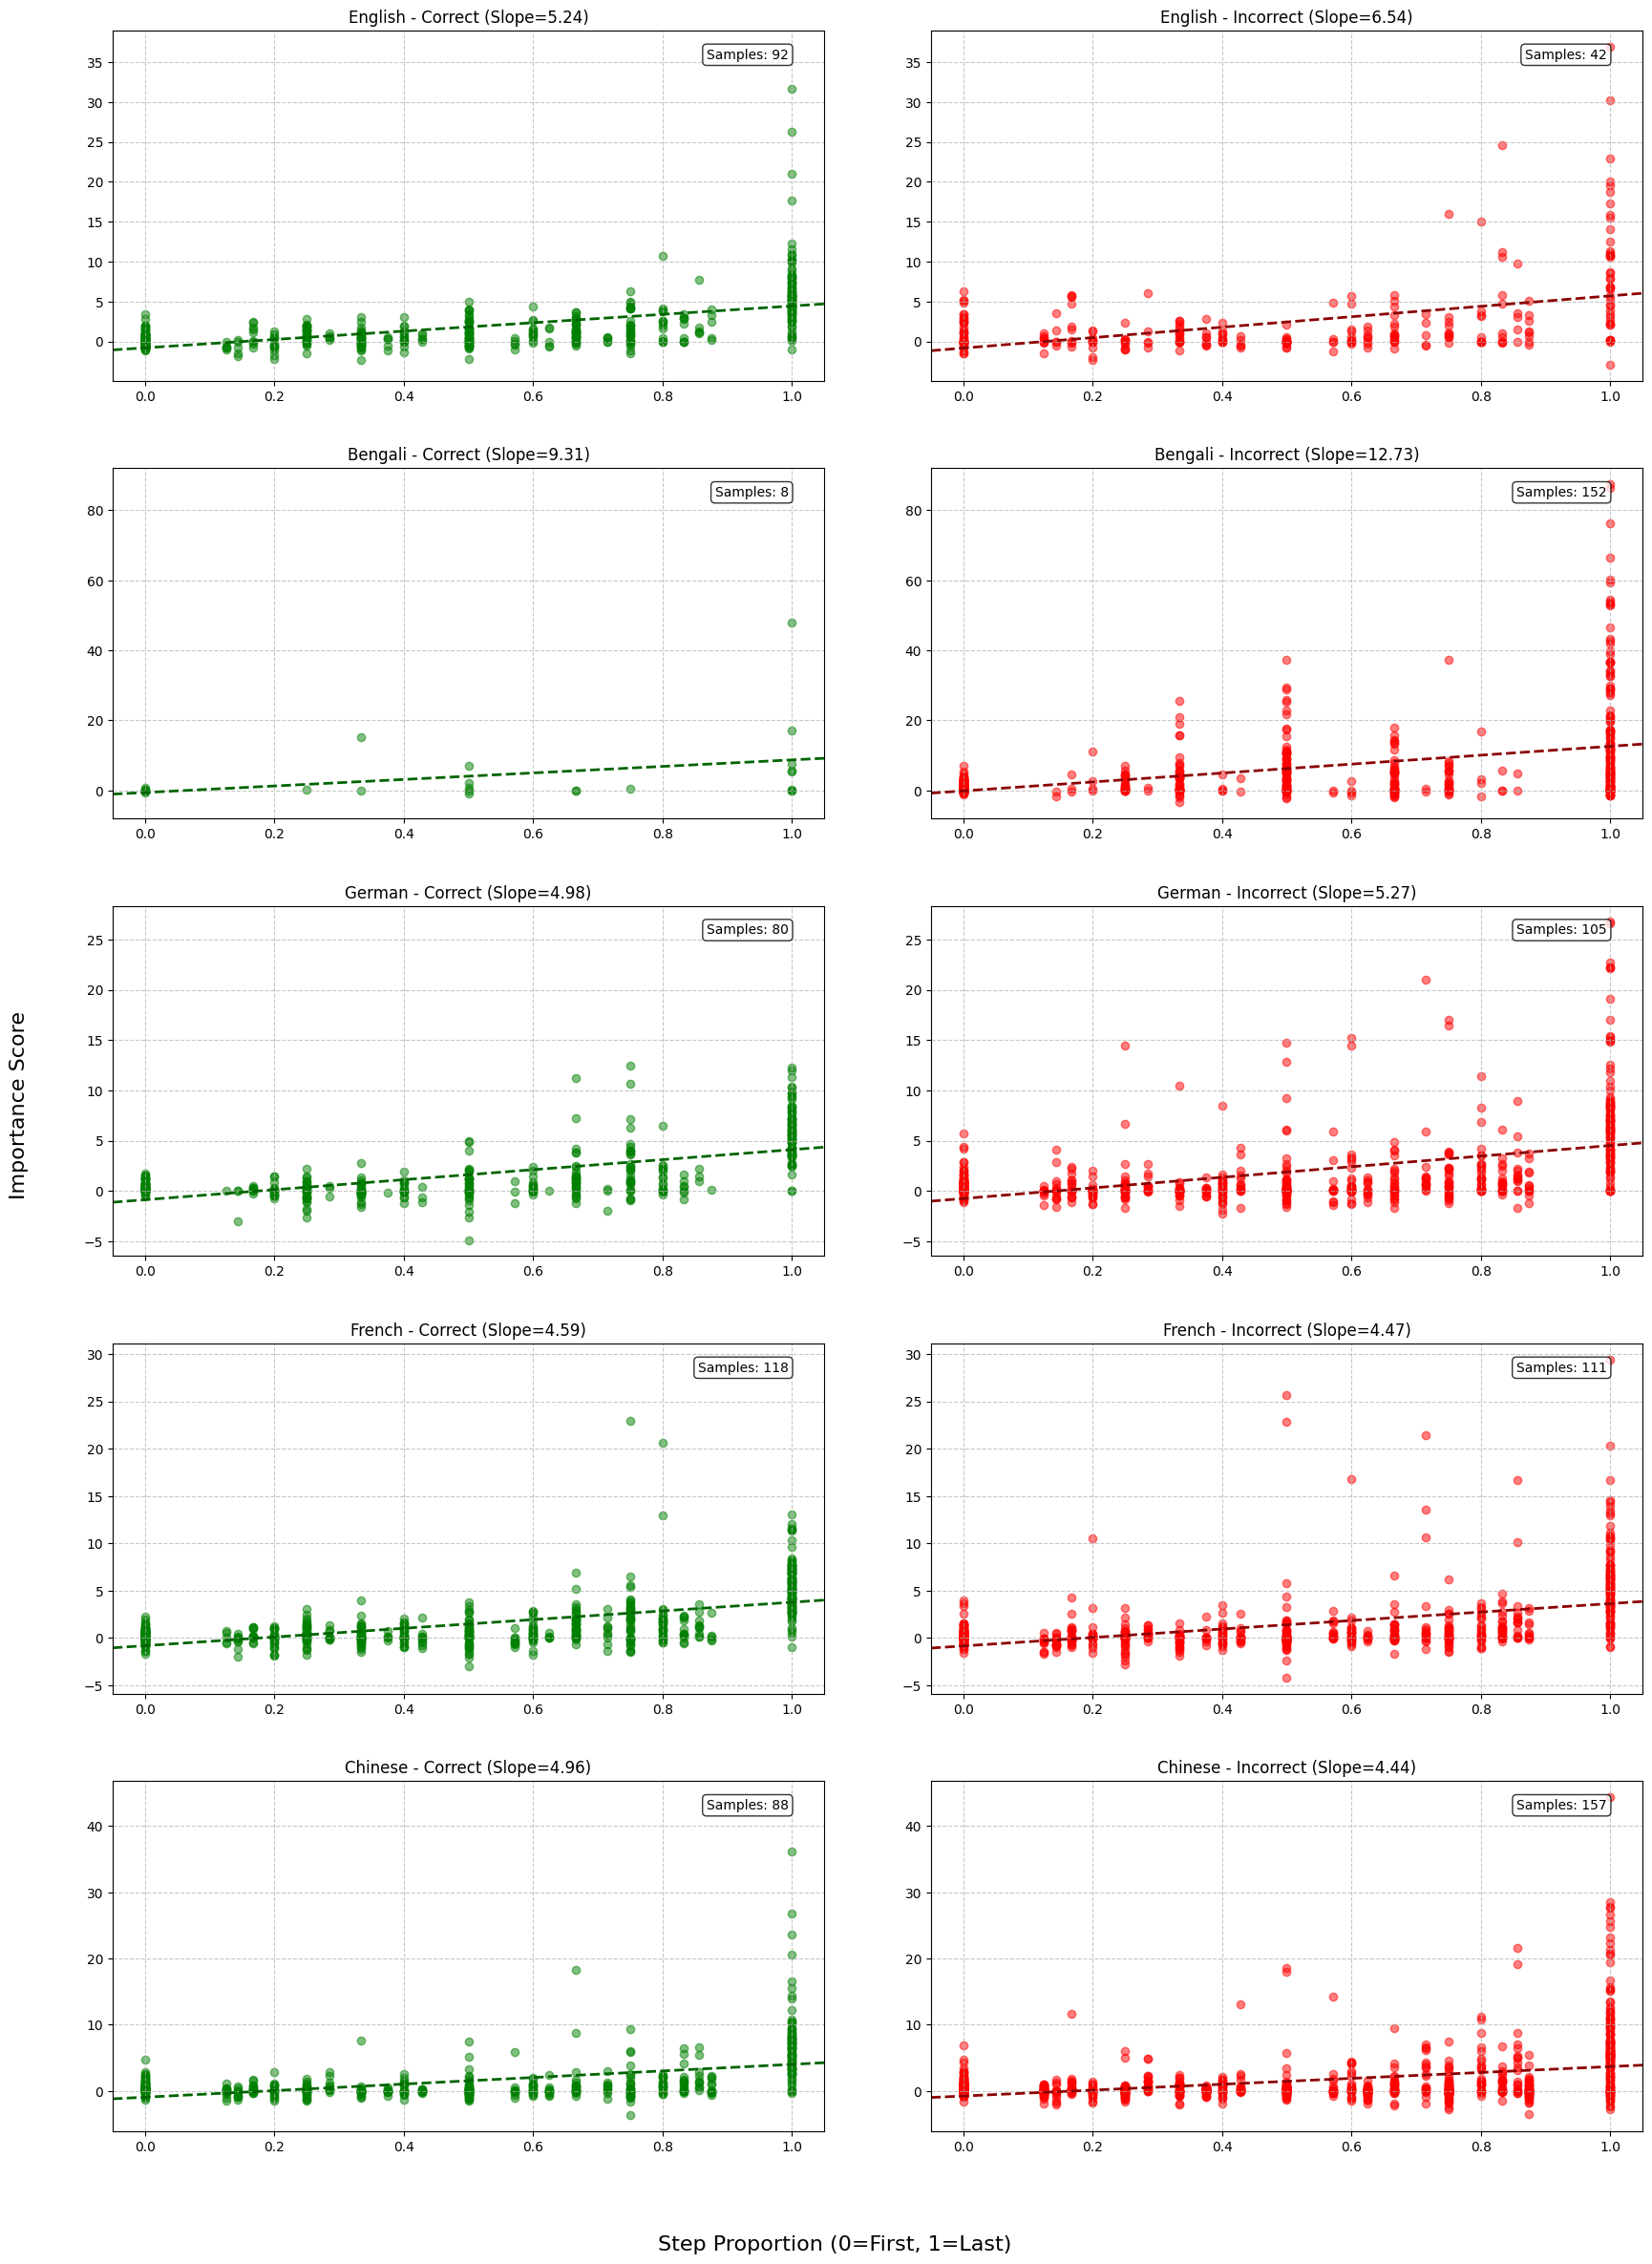

{'en': 0, 'bn': 33, 'de': 0, 'fr': 0, 'zh': 0}

In [86]:
def plot_step_importance_by_position(model_name, languages=None, save_dir='results/plots/', plot_filename=None, figsize=(18, 25)):
    """
    Plot step importance by position for correct and incorrect answers across languages.
    
    Parameters:
    -----------
    model_name : str
        Name of the model being analyzed (e.g., 'Qwen2.5-1.5B-Instruct').
        Used for retrieving data files and generating default filename.
    languages : list or None
        List of language codes to analyze. If None, defaults to ['en', 'bn', 'de', 'fr', 'zh'].
    save_dir : str
        Directory to save the plot. Default is 'results/plots/'.
    plot_filename : str or None
        Filename for saving the plot. If None, will be created based on model name.
        
    Returns:
    --------
    dict
        Dictionary containing the invalid counts for each language.
    """
    from matplotlib.gridspec import GridSpec
    
    # Set default languages if not provided
    if languages is None:
        languages = ['en', 'bn', 'de', 'fr', 'zh']
    
    # Set default filename if not provided
    if plot_filename is None:
        plot_filename = f'step_importance_by_position_predicted_{model_name}.png'
    
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Complete path for saving the plot
    plot_path = os.path.join(save_dir, plot_filename)
    
    # Set up a figure with subplots for each language and correctness
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(len(languages), 2, figure=fig, hspace=0.25, wspace=0.15)  # Reduced spacing between plots
    
    # Track invalid responses
    invalid_counts = {}
    
    # Process each language
    for i, lang in enumerate(languages):
        # Define file path
        file_path = f'results/contextcite/contextcite_{lang}_{model_name}_COT.json'
        
        try:
            # Load data
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            # Initialize lists to store processed data
            x_correct = []  # Proportion values for correct answers
            y_correct = []  # Importance values for correct answers
            x_incorrect = []  # Proportion values for incorrect answers
            y_incorrect = []  # Importance values for incorrect answers
            invalid_count = 0
            all_importance_values = []  # For calculating consistent y limits
            
            # Track correct and incorrect sample counts properly
            correct_sample_count = 0
            incorrect_sample_count = 0
            
            # Process each sample
            for sample in data:
                # Skip invalid model answers
                model_answer = sample.get('model_gen_answer')
                if model_answer == '[invalid]' or model_answer is None:
                    invalid_count += 1
                    continue
                
                # Try to convert to float for comparison
                try:
                    model_answer_float = float(model_answer)
                    actual_answer_float = float(sample['actual_answer'])
                    is_correct = abs(model_answer_float - actual_answer_float) < 1e-6
                except (ValueError, TypeError):
                    # If conversion fails, compare as is
                    is_correct = str(model_answer) == str(sample['actual_answer'])
                
                # Increment the appropriate sample counter
                if is_correct:
                    correct_sample_count += 1
                else:
                    incorrect_sample_count += 1
                
                # Get all calculation steps (including the header "Step-by-Step Answer:")
                calculation_steps = sample['lines_and_importance']
                
                # Calculate total number of steps
                total_steps = len(calculation_steps)
                
                # Skip entries with no steps
                if total_steps == 0:
                    continue
                    
                # Process each step's importance
                for step_idx, line_data in enumerate(calculation_steps):
                    # Calculate proportion to range from 0 (first step) to 1 (last step)
                    # If there's only one step, proportion will be 0
                    proportion = step_idx / (total_steps - 1) if total_steps > 1 else 0
                    importance = line_data['importance']
                    
                    # Track all importance values for y-limit calculation
                    all_importance_values.append(importance)
                    
                    # Add to appropriate list based on correctness
                    if is_correct:
                        x_correct.append(proportion)
                        y_correct.append(importance)
                    else:
                        x_incorrect.append(proportion)
                        y_incorrect.append(importance)
            
            # Record invalid count
            invalid_counts[lang] = invalid_count
            
            # Calculate consistent y limits for both plots
            if all_importance_values:
                y_min = min(all_importance_values)
                y_max = max(all_importance_values)
                # Add some padding
                y_range = y_max - y_min
                y_min -= y_range * 0.05
                y_max += y_range * 0.05
            else:
                # Default if no data
                y_min, y_max = -5, 5
            
            # Create subplot for CORRECT answers
            ax_correct = fig.add_subplot(gs[i, 0])
            
            # Plot scatter points for correct answers
            ax_correct.scatter(x_correct, y_correct, alpha=0.5, color='green')
            
            # Linear regression slope for correct answers
            correct_slope = None
            if len(x_correct) > 3:
                # Use a linear fit (degree=1)
                z_correct = np.polyfit(x_correct, y_correct, 1)
                p_correct = np.poly1d(z_correct)
                correct_slope = z_correct[0]  # First coefficient is the slope
                
                # Generate points for the line
                x_line = np.linspace(-0.05, 1.05, 100)
                y_line = p_correct(x_line)
                
                # Plot regression line
                ax_correct.plot(x_line, y_line, color='darkgreen', linestyle='--', linewidth=2)
            
            # Add the slope to the title if available
            if correct_slope is not None:
                title = f'{LANGUAGE_MAPPING[lang]} - Correct (Slope={correct_slope:.2f})'
            else:
                title = f'{LANGUAGE_MAPPING[lang]} - Correct'
                
            ax_correct.set_title(title, fontsize=12)
            ax_correct.set_xlim(-0.05, 1.05)  # Extended x limits for better visibility
            ax_correct.set_ylim(y_min, y_max)  # Use consistent y limits
            ax_correct.grid(True, linestyle='--', alpha=0.7)
            
            # Add the correct sample count in the top right corner
            ax_correct.text(0.95, 0.95, f"Samples: {correct_sample_count}", 
                    transform=ax_correct.transAxes, ha='right', va='top', 
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            # Create subplot for INCORRECT answers
            ax_incorrect = fig.add_subplot(gs[i, 1])
            
            # Plot scatter points for incorrect answers
            ax_incorrect.scatter(x_incorrect, y_incorrect, alpha=0.5, color='red')
            
            # Linear regression slope for incorrect answers
            incorrect_slope = None
            if len(x_incorrect) > 3:
                # Use a linear fit (degree=1)
                z_incorrect = np.polyfit(x_incorrect, y_incorrect, 1)
                p_incorrect = np.poly1d(z_incorrect)
                incorrect_slope = z_incorrect[0]  # First coefficient is the slope
                
                # Generate points for the line
                x_line = np.linspace(-0.05, 1.05, 100)
                y_line = p_incorrect(x_line)
                
                # Plot regression line
                ax_incorrect.plot(x_line, y_line, color='darkred', linestyle='--', linewidth=2)
            
            # Add the slope to the title if available
            if incorrect_slope is not None:
                title = f'{LANGUAGE_MAPPING[lang]} - Incorrect (Slope={incorrect_slope:.2f})'
            else:
                title = f'{LANGUAGE_MAPPING[lang]} - Incorrect'
                
            ax_incorrect.set_title(title, fontsize=12)
            ax_incorrect.set_xlim(-0.05, 1.05)  # Extended x limits for better visibility
            ax_incorrect.set_ylim(y_min, y_max)  # Use consistent y limits
            ax_incorrect.grid(True, linestyle='--', alpha=0.7)
            
            # Add the incorrect sample count in the top right corner
            ax_incorrect.text(0.95, 0.95, f"Samples: {incorrect_sample_count}", 
                    transform=ax_incorrect.transAxes, ha='right', va='top', 
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
        except Exception as e:
            print(f"Error processing {lang}: {e}")
    
    # Add a common y-axis label with more space
    fig.text(0.02, 0.5, 'Importance Score', va='center', rotation='vertical', fontsize=16)
    
    # Add a common x-axis label (single instance) - properly centered
    fig.text(0.5, 0.02, 'Step Proportion (0=First, 1=Last)', ha='center', fontsize=16)
    
    # Adjust layout with optimized spacing
    # fig.suptitle('Step Importance by Proportion of Position Across Languages', fontsize=18)
    plt.subplots_adjust(top=0.95, bottom=0.07, left=0.08, right=0.97, hspace=0.3, wspace=0.2)
    
    # Save the figure
    plt.savefig(plot_path, dpi=300)
    
    # Print invalid counts
    print("\nInvalid response counts:")
    for lang, count in invalid_counts.items():
        print(f"{LANGUAGE_MAPPING[lang]}: {count}")
    
    plt.show()
    
    return invalid_counts

plot_step_importance_by_position(qwen_instruct)


Invalid response counts:
English: 0
Chinese: 11


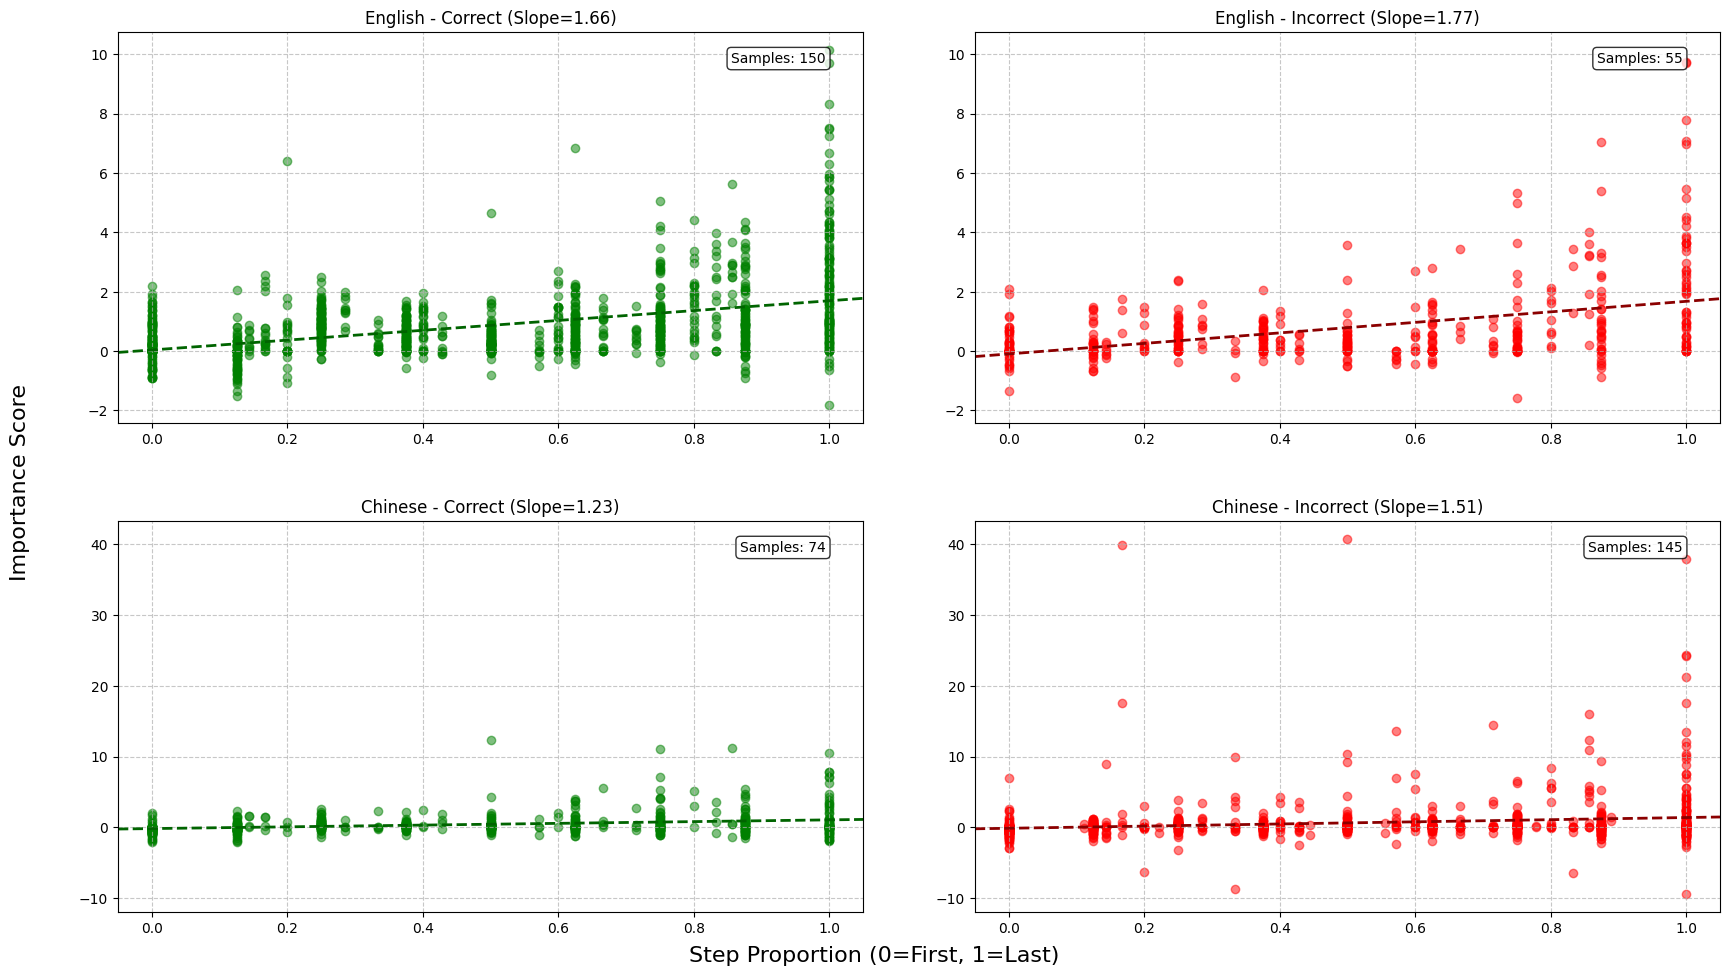

{'en': 0, 'zh': 11}

In [87]:
plot_step_importance_by_position(qwen_reasoning, languages=['en', 'zh'], figsize=(18, 10))

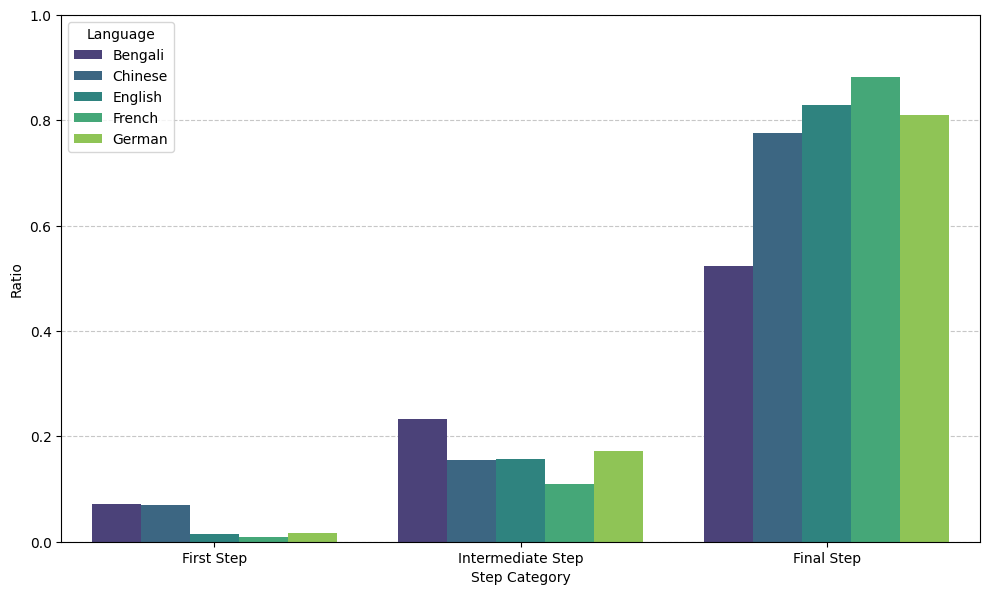

Plot saved as 'results/plots/highest_explanation_step_normalized_Qwen2.5-1.5B-Instruct.png'


In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
from constants import LANGUAGE_MAPPING

def plot_highest_explanation_step_normalized(model_name, languages=None, save_dir='results/plots/', plot_filename=None):
    """
    Plot the normalized distribution of the step with the highest explanation score categorized as
    "First Step," "Intermediate Step," or "Final Step" for each language.

    Parameters:
    -----------
    model_name : str
        Name of the model being analyzed (e.g., 'Qwen2.5-1.5B-Instruct').
    languages : list or None
        List of language codes to analyze. If None, defaults to ['en', 'bn', 'de', 'fr', 'zh'].
    save_dir : str
        Directory to save the plot. Default is 'results/plots/'.
    plot_filename : str or None
        Filename for saving the plot. If None, will be created based on model name.

    Returns:
    --------
    None
    """
    if languages is None:
        languages = ['en', 'bn', 'de', 'fr', 'zh']
    
    if plot_filename is None:
        plot_filename = f'highest_explanation_step_normalized_{model_name}.png'
    
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    plot_path = os.path.join(save_dir, plot_filename)
    
    data = []
    language_counts = {}

    for lang in languages:
        file_path = f'results/contextcite/contextcite_{lang}_{model_name}_COT.json'
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                samples = json.load(f)
            
            # Count total rows for normalization
            language_counts[lang] = len(samples)
            
            for sample in samples:
                # Skip invalid model answers
                model_answer = sample.get('model_gen_answer')
                if model_answer == '[invalid]' or model_answer is None:
                    continue
                
                # Extract importance scores
                steps = sample['lines_and_importance']
                if not steps:
                    continue
                
                # Find the step with the highest explanation score
                max_step_idx = max(range(len(steps)), key=lambda i: steps[i]['importance'])
                
                # Categorize the step
                if max_step_idx == 0:
                    step_category = "First Step"
                elif max_step_idx == len(steps) - 1:
                    step_category = "Final Step"
                else:
                    step_category = "Intermediate Step"
                
                # Append to data
                data.append({
                    'Language': LANGUAGE_MAPPING.get(lang, lang),
                    'Step Category': step_category,
                    'Language Code': lang  # Keep the language code for normalization
                })
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Normalize counts by the total number of rows per language
    df['Count'] = 1
    df_grouped = df.groupby(['Language', 'Step Category', 'Language Code']).sum().reset_index()
    df_grouped['Total'] = df_grouped['Language Code'].map(language_counts)
    df_grouped['Ratio'] = df_grouped['Count'] / df_grouped['Total']
    
    # Set the order of the step categories
    step_order = ["First Step", "Intermediate Step", "Final Step"]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_grouped,
        x='Step Category',
        y='Ratio',
        hue='Language',
        order=step_order,
        palette='viridis'
    )
    
    # Add grid behind the bars
    ax.set_axisbelow(True)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Customize the plot
    plt.ylabel('Ratio')
    plt.xlabel('Step Category')
    plt.legend(title='Language')
    plt.tight_layout()
    plt.ylim(0, 1)  # Set y-axis limits to [0, 1]
    
    # Save and show the plot
    plt.savefig(plot_path, dpi=300)
    plt.show()
    print(f"Plot saved as '{plot_path}'")

# Example usage
plot_highest_explanation_step_normalized("Qwen2.5-1.5B-Instruct")

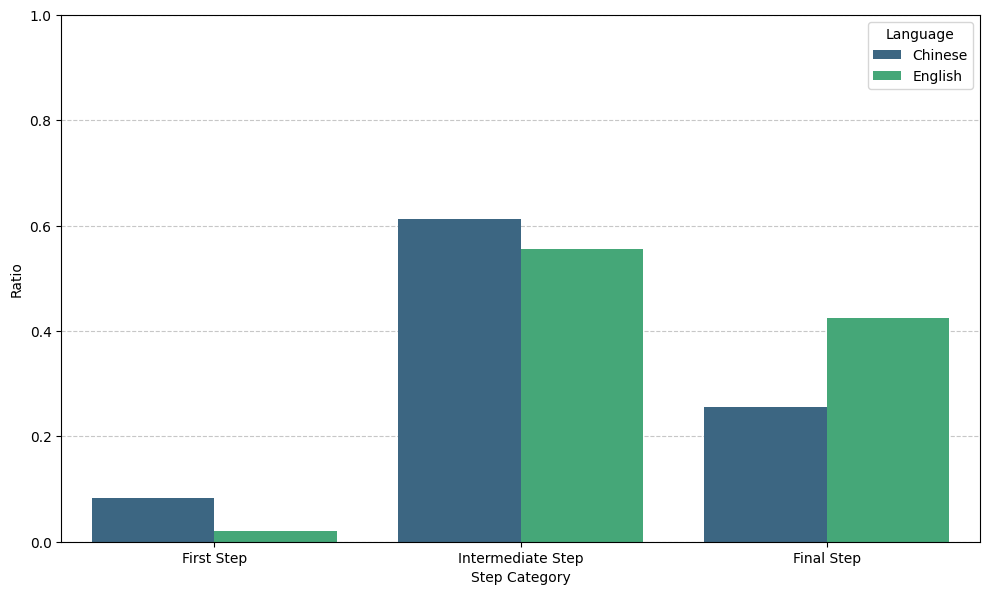

Plot saved as 'results/plots/highest_explanation_step_normalized_DeepSeek-R1-Distill-Qwen-1.5B.png'


In [94]:
plot_highest_explanation_step_normalized(qwen_reasoning, languages=['en', 'zh'])

In [44]:
import pandas as pd
import json

def compute_parsed_entries_ratio(model_name, languages=None):
    """
    Compute the number of entries in the JSON that can be properly parsed (sum of correct and incorrect)
    divided by 250 for the given model and languages.

    Parameters:
    -----------
    model_name : str
        Name of the model being analyzed (e.g., 'Qwen2.5-1.5B-Instruct').
    languages : list
        List of language codes to analyze (e.g., ['en', 'zh']).

    Returns:
    --------
    pd.DataFrame
        DataFrame containing the language, total parsed entries, and ratio (parsed entries / 250).
    """
    results = []
    
    if languages is None:
        languages = ['en', 'bn', 'de', 'fr', 'zh']

    for lang in languages:
        file_path = f'results/contextcite/contextcite_{lang}_{model_name}_COT.json'
        try:
            # Load the JSON file
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)

            # Count valid entries (correct + incorrect)
            valid_entries = 0
            for sample in data:
                model_answer = sample.get('model_gen_answer')
                if model_answer != '[invalid]' and model_answer is not None:
                    valid_entries += 1

            # Compute the ratio
            ratio = valid_entries / 250
            results.append({'Language': lang, 'Parsed Entries': valid_entries, 'Ratio': ratio})

        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            results.append({'Language': lang, 'Parsed Entries': 0, 'Ratio': 0})

    # Convert results to a DataFrame
    df = pd.DataFrame(results)
    return df

# Example usage
parsed_entries_df = compute_parsed_entries_ratio(qwen_instruct)
display(parsed_entries_df)

,Language,Parsed Entries,Ratio
0,en,134,0.536
1,bn,160,0.640
2,de,185,0.740
3,fr,229,0.916
4,zh,245,0.980


In [45]:
parsed_entries_df = compute_parsed_entries_ratio(qwen_reasoning, languages=['en', 'zh'])
display(parsed_entries_df)

,Language,Parsed Entries,Ratio
0,en,205,0.820
1,zh,219,0.876


## Attempting to predict whether the answer will be correct

c:\Users\User\.conda\envs\transformer\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


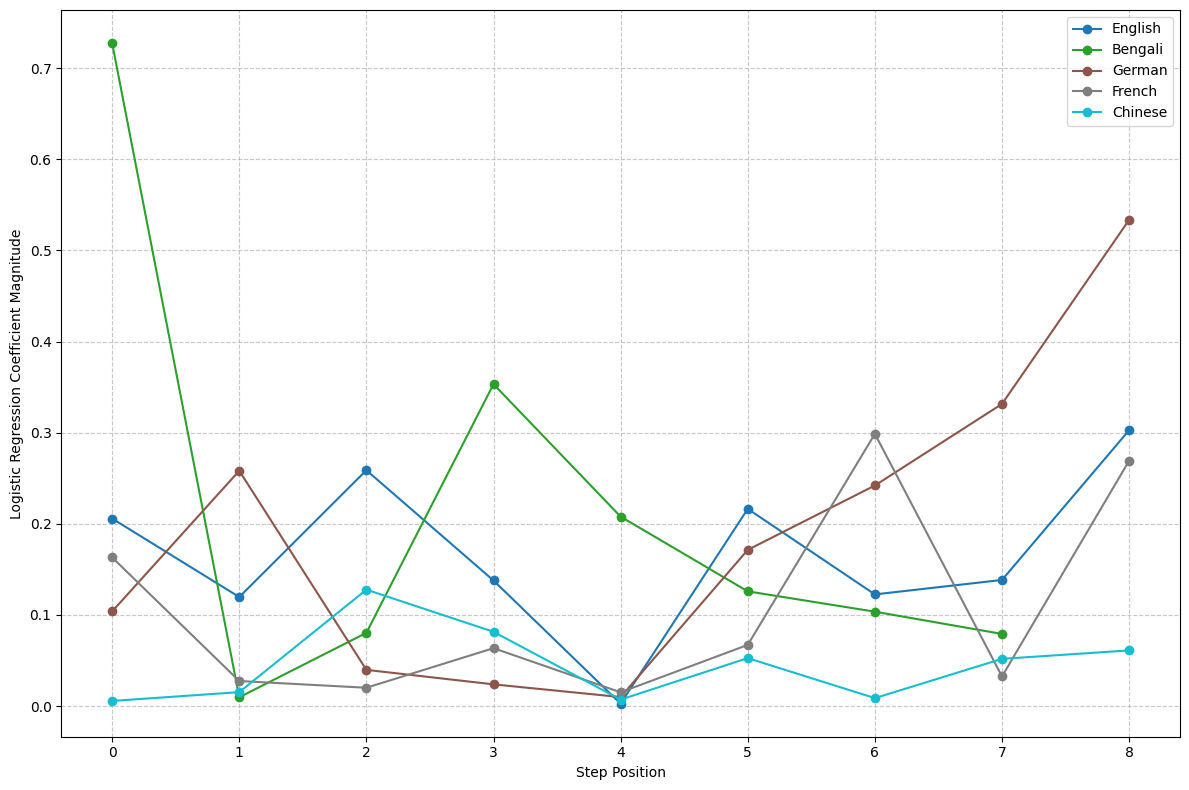

Plot saved as 'results/plots/step_importance_by_position_Qwen2.5-1.5B-Instruct.png'


In [78]:
def analyze_language_importance(model_name, languages=['en', 'bn', 'de', 'fr', 'zh'], save_dir='results/plots/'):
    """
    Analyze the importance of reasoning steps across languages for a given model.
    
    Parameters:
    -----------
    model_name : str
        Name of the model being analyzed (e.g., 'Qwen2.5-1.5B-Instruct')
    languages : list
        List of language codes to analyze (e.g., ['en', 'zh'])
    save_dir : str
        Directory to save plots and results
        
    Returns:
    --------
    tuple
        (stats_df, performance_df, feature_importance_dfs)
    """
    import json
    import numpy as np
    import pandas as pd
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    import matplotlib.pyplot as plt
    from constants import LANGUAGE_MAPPING
    import os
    
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Create DataFrames to store results
    stats_df = pd.DataFrame(columns=[
        'Language', 'Total Samples', 'Correct Samples', 'Correct %', 
        'Incorrect Samples', 'Incorrect %', 'Train Size', 'Val Size'
    ])
    
    performance_df = pd.DataFrame(columns=[
        'Language', 'Train Accuracy', 'Val Accuracy', 'Val Precision', 
        'Val Recall', 'Val F1 Score'
    ])
    
    # Dictionary to store feature importance DataFrames for each language
    feature_importance_dfs = {}
    language_results = {}
    max_steps_overall = 0
    
    # First pass to find max_steps across all languages
    for lang in languages:
        file_path = f'results/contextcite/contextcite_{lang}_{model_name}_COT.json'
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                
            for sample in data:
                # Skip invalid model answers
                model_answer = sample.get('model_gen_answer')
                if model_answer == '[invalid]' or not isinstance(model_answer, (int, float, str)):
                    continue
                
                # Get number of steps 
                steps = len(sample['lines_and_importance'])
                if steps > max_steps_overall:
                    max_steps_overall = steps
        except Exception as e:
            print(f"Error reading {lang}: {e}")
    
    # Process each language separately
    for lang in languages:
        file_path = f'results/contextcite/contextcite_{lang}_{model_name}_COT.json'
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            importances = []
            correctness = []
            
            for sample in data:
                # Skip invalid model answers
                model_answer = sample.get('model_gen_answer')
                if model_answer == '[invalid]' or not isinstance(model_answer, (int, float, str)):
                    continue
                
                # Determine if answer is correct
                try:
                    model_answer_float = float(model_answer)
                    actual_answer_float = float(sample['actual_answer'])
                    is_correct = abs(model_answer_float - actual_answer_float) < 1e-6
                except (ValueError, TypeError):
                    # If conversion fails, compare as is
                    is_correct = str(model_answer) == str(sample['actual_answer'])
                
                # Extract importance values
                sample_importances = [step['importance'] for step in sample['lines_and_importance']]
                
                # Pad with zeros to ensure consistent length
                padded_importances = sample_importances + [0] * (max_steps_overall - len(sample_importances))
                
                importances.append(padded_importances)
                correctness.append(1 if is_correct else 0)
            
            # Convert to numpy arrays
            X = np.array(importances)
            y = np.array(correctness)
            
            if len(y) > 0:
                # Store results for this language
                language_results[lang] = (X, y)
                
                # Create stratified train-val split (80-20)
                X_train, X_val, y_train, y_val = train_test_split(
                    X, y, test_size=0.2, random_state=42, stratify=y
                )
                
                # Record dataset statistics
                lang_name = LANGUAGE_MAPPING.get(lang, lang)
                stats_df = pd.concat([
                    stats_df, 
                    pd.DataFrame([{
                        'Language': lang_name,
                        'Total Samples': len(y),
                        'Correct Samples': sum(y),
                        'Correct %': f"{sum(y)/len(y)*100:.1f}%",
                        'Incorrect Samples': len(y) - sum(y),
                        'Incorrect %': f"{(len(y) - sum(y))/len(y)*100:.1f}%",
                        'Train Size': len(y_train),
                        'Val Size': len(y_val)
                    }])
                ], ignore_index=True)
                
                # Train Logistic Regression
                lr = LogisticRegression(max_iter=1000, random_state=42)
                lr.fit(X_train, y_train)
                
                # Logistic Regression Predictions
                lr_train_preds = lr.predict(X_train)
                lr_val_preds = lr.predict(X_val)
                
                # Add Logistic Regression performance to DataFrame
                performance_df = pd.concat([
                    performance_df,
                    pd.DataFrame([{
                        'Language': lang_name,
                        'Train Accuracy': f"{accuracy_score(y_train, lr_train_preds):.4f}",
                        'Val Accuracy': f"{accuracy_score(y_val, lr_val_preds):.4f}",
                        'Val Precision': f"{precision_score(y_val, lr_val_preds):.4f}",
                        'Val Recall': f"{recall_score(y_val, lr_val_preds):.4f}",
                        'Val F1 Score': f"{f1_score(y_val, lr_val_preds):.4f}"
                    }])
                ], ignore_index=True)
                
                # Create feature importance DataFrame
                feature_importance_df = pd.DataFrame({
                    'Step': range(X.shape[1]),
                    'Importance': np.abs(lr.coef_[0])
                })
                
                # Store feature importance DataFrame
                feature_importance_dfs[lang] = feature_importance_df
            else:
                print(f"No valid samples for {lang}")
                
        except Exception as e:
            print(f"Error processing {lang}: {e}")
    
    # Plot feature importance as line plot
    if feature_importance_dfs:
        plt.figure(figsize=(12, 8))
        
        # Set up colors for the plot
        colors = plt.cm.tab10(np.linspace(0, 1, len(languages)))
        
        # Plot each language
        for i, lang in enumerate(languages):
            if lang in feature_importance_dfs:
                df = feature_importance_dfs[lang]
                # Sort by step index to ensure they're in original order
                df_sorted = df.sort_values('Step')
                
                # Get step indices and corresponding importances
                steps = df_sorted['Step'].values
                importances = df_sorted['Importance'].values
                
                # Plot only non-zero steps
                non_zero_mask = importances > 0
                if np.any(non_zero_mask):
                    plt.plot(
                        steps[non_zero_mask], 
                        importances[non_zero_mask], 
                        marker='o', 
                        linestyle='-', 
                        color=colors[i], 
                        label=LANGUAGE_MAPPING.get(lang, lang)
                    )
        
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xlabel('Step Position')
        plt.ylabel('Logistic Regression Coefficient Magnitude')
        # plt.title(f'Feature Importance by Step Position for Different Languages ({model_name})')
        plt.legend()
        plt.tight_layout()
        
        # Save the plot
        plot_path = os.path.join(save_dir, f'step_importance_by_position_{model_name}.png')
        plt.savefig(plot_path, dpi=300)
        plt.show()
        print(f"Plot saved as '{plot_path}'")
    
    # Save DataFrames to CSV
    stats_df.to_csv(os.path.join(save_dir, 'language_statistics.csv'), index=False)
    performance_df.to_csv(os.path.join(save_dir, 'language_performance.csv'), index=False)
    
    # Return the results
    return stats_df, performance_df, feature_importance_dfs

stats_df, performance_df, _ = analyze_language_importance(qwen_instruct)

In [79]:
# Display final DataFrames
print("\n=== DATASET STATISTICS ===")
display(stats_df)


=== DATASET STATISTICS ===


,Language,Total Samples,Correct Samples,Correct %,Incorrect Samples,Incorrect %,Train Size,Val Size
0,English,134,92,68.7%,42,31.3%,107,27
1,Bengali,160,8,5.0%,152,95.0%,128,32
2,German,185,80,43.2%,105,56.8%,148,37
3,French,229,118,51.5%,111,48.5%,183,46
4,Chinese,245,88,35.9%,157,64.1%,196,49


In [80]:
print("\n=== MODEL PERFORMANCE ===")
display(performance_df)


=== MODEL PERFORMANCE ===


,Language,Train Accuracy,Val Accuracy,Val Precision,Val Recall,Val F1 Score
0,English,0.7944,0.6667,0.7083,0.8947,0.7907
1,Bengali,0.9531,0.9375,0.0000,0.0000,0.0000
2,German,0.6959,0.6486,0.5789,0.6875,0.6286
3,French,0.6284,0.5217,0.5294,0.7500,0.6207
4,Chinese,0.6531,0.6122,0.3333,0.0556,0.0952


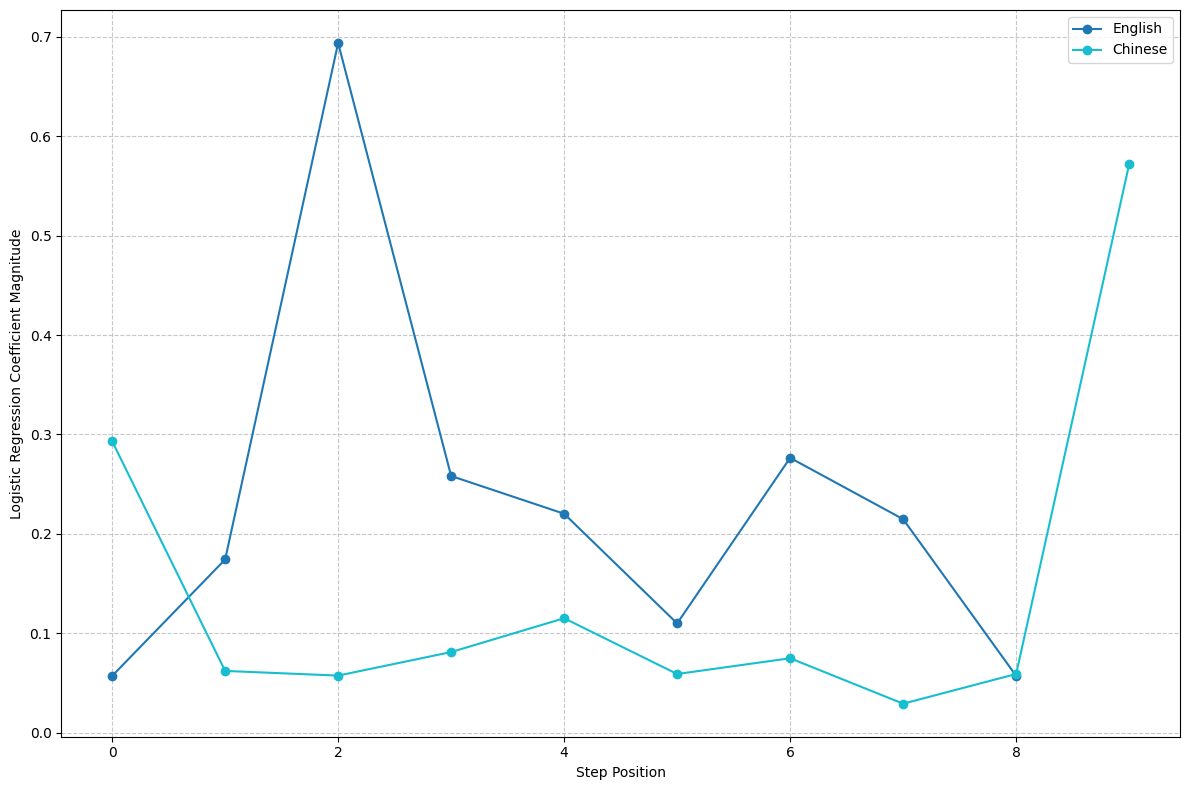

Plot saved as 'results/plots/step_importance_by_position_DeepSeek-R1-Distill-Qwen-1.5B.png'


In [81]:
stats_df, performance_df, _ = analyze_language_importance(qwen_reasoning, languages=['en', 'zh'])

In [82]:
display(stats_df)

,Language,Total Samples,Correct Samples,Correct %,Incorrect Samples,Incorrect %,Train Size,Val Size
0,English,205,150,73.2%,55,26.8%,164,41
1,Chinese,219,74,33.8%,145,66.2%,175,44


In [83]:
display(performance_df)

,Language,Train Accuracy,Val Accuracy,Val Precision,Val Recall,Val F1 Score
0,English,0.7500,0.7317,0.7436,0.9667,0.8406
1,Chinese,0.6686,0.6136,0.2500,0.0667,0.1053
